In [55]:
# import lib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.datasets import make_moons,make_classification,make_regression,make_circles
import sys
from mpl_toolkits.mplot3d import Axes3D 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

np.random.seed(23)
np.set_printoptions(precision=3,suppress=True)

def _sym_decorrelation(W):
    """ Symmetric decorrelation
    i.e. W <- (W * W.T) ^{-1/2} * W
    """
    s, u = np.linalg.eigh(np.dot(W, W.T))
    # u (resp. s) contains the eigenvectors (resp. square roots of
    # the eigenvalues) of W * W.T
    return np.dot(np.dot(u * (1. / (np.sqrt(s+1e-2)), u.T), W)

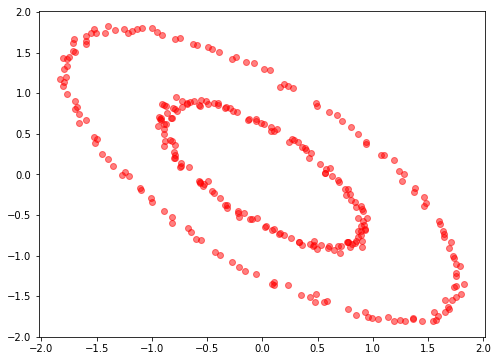

In [14]:
# See the data 
# X, y = make_moons(n_samples=300, noise=0.02)
X, y = make_circles(n_samples=300, noise=0.02,factor=0.5)
X = X @ np.array([
    [1,0],
    [1,2]
])
# X,y = make_regression(n_samples=400, n_features=1,noise=5); X = np.concatenate((X,y[:,None]),1) 

# ======== WE ARE CENTERING AND STD =======
X[:,1] = -X[:,1]
X = (X - X.mean(0))/X.std(0)
# ======== WE ARE CENTERING AND STD =======

plt.figure(figsize=(8,6))
# plt.scatter(X[y==0, 0], X[y==0, 1], color='red', alpha=0.5)
# plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
plt.scatter(X[:, 0], X[:,1], color='red', alpha=0.5)
plt.show()

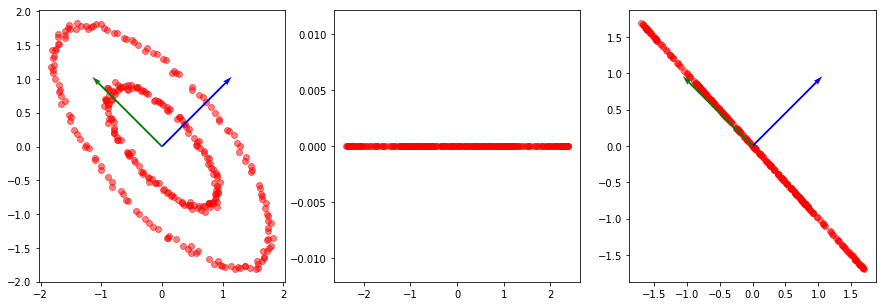

In [15]:
# traditional PCA

# 1. projection
cov = X.T @ X / X.shape[1]
evalue,evector = np.linalg.eig(cov)
idx = np.argsort(evalue)[::-1]
evecs = evector[:,idx]
projected = X @ evecs[:,0]
recovered = projected[:,None] @ evecs[:,0][:,None].T

# 2. recover
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.scatter(X[:, 0], X[:,1], color='red', alpha=0.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[0,0],evector[0,1], color=['b'], scale=2.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[1,0],evector[1,1], color=['g'], scale=2.5)

plt.subplot(1, 3, 2)
plt.scatter(projected,np.zeros(len(projected)), color='red', alpha=0.5)

plt.subplot(1, 3, 3)
plt.scatter(recovered[:, 0], recovered[:,1], color='red', alpha=0.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[0,0],evector[0,1], color=['b'], scale=2.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[1,0],evector[1,1], color=['g'], scale=2.5)

plt.show()

Before :  1.7383216366874876  After :  1.0


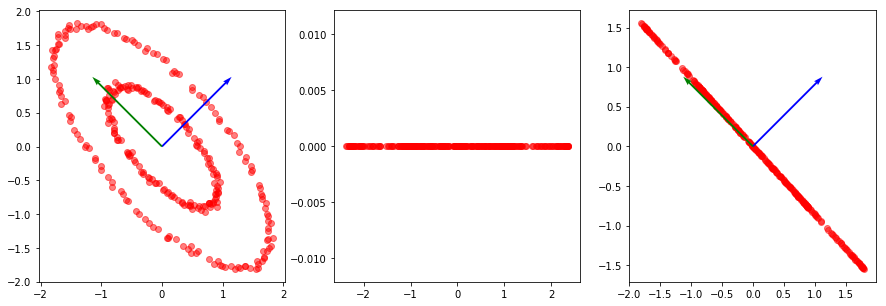

In [16]:
# simple method
w = np.random.randn(2,1)
print('Before : ',np.sqrt(np.sum(w**2)),end=' ')
w = w/(np.sqrt(np.sum(w**2)))
print(' After : ',np.sqrt(np.sum(w**2)))
w = -2 * X.T @ X @ w
# w = (np.eye(2)+0.5 * X.T @ X ) @ w
w = w/(np.sqrt(np.sum(w**2)))

projected_mine = X @ w
recover_mine   = projected_mine @ w.T

plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.scatter(X[:, 0], X[:,1], color='red', alpha=0.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[0,0],evector[0,1], color=['b'], scale=2.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[1,0],evector[1,1], color=['g'], scale=2.5)

plt.subplot(1, 3, 2)
plt.scatter(projected_mine,np.zeros(len(projected)), color='red', alpha=0.5)

plt.subplot(1, 3, 3)
plt.scatter(recover_mine[:, 0], recover_mine[:,1], color='red', alpha=0.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[0,0],evector[0,1], color=['b'], scale=2.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[1,0],evector[1,1], color=['g'], scale=2.5)

plt.show()

In [17]:
print(np.allclose(recover_mine,recovered,atol=0.01))
print(np.allclose(np.sign(w)*w,np.sign(evecs[:,0])*evecs[:,0],atol=0.01))
print(np.sign(w)*w)
print(np.sign(evecs[:,0])*evecs[:,0])

False
False
[[0.758]
 [0.652]]
[0.707 0.707]


(300, 2)
Iter :  0  Loss:  13.532096668810333
Iter :  20  Loss:  13.53209754789978
Iter :  40  Loss:  13.532098431597365
Iter :  60  Loss:  13.532099315198892
Iter :  80  Loss:  13.532100196992076


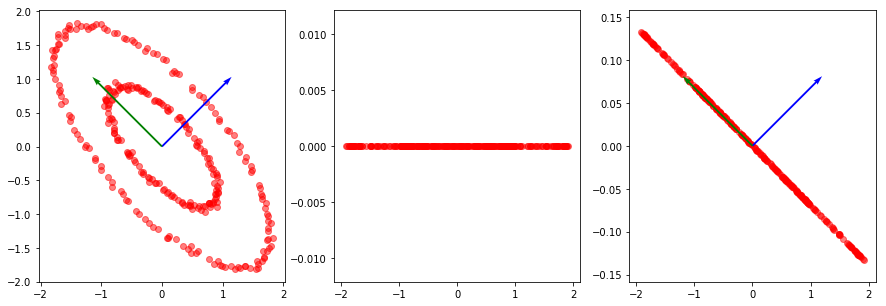

False
False
[[0.998]
 [0.069]]
[0.707 0.707]


In [18]:
# iterative
# w = np.random.uniform(0,1,size=(2,1))
w = np.random.randn(2,1)
w = w/(np.sqrt(np.sum(w**2)))
m = np.zeros_like(w)
temp_X = np.copy(X)
print(temp_X.shape)

for iter in range(100):
    cum_loss = 0
    temp_X   = shuffle(temp_X)
    for mini_batch in range(0,len(X),10):
        current_batch = temp_X[mini_batch:mini_batch+10]
        loss          = current_batch - current_batch@w@w.T
        grad          = (current_batch.T@loss + loss.T @ current_batch) @ w
        m = 0.9 * m + 0.1 * grad
        w = w - 0.00000000001* m
        w = w/(np.sqrt(np.sum(w**2)))
        cum_loss      = cum_loss + (loss**2).mean()
    if iter%20==0:print('Iter : ',iter," Loss: ",cum_loss)

projected_mine = X @ w
recover_mine   = projected_mine @ w.T

plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.scatter(X[:, 0], X[:,1], color='red', alpha=0.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[0,0],evector[0,1], color=['b'], scale=2.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[1,0],evector[1,1], color=['g'], scale=2.5)

plt.subplot(1, 3, 2)
plt.scatter(projected_mine,np.zeros(len(projected)), color='red', alpha=0.5)

plt.subplot(1, 3, 3)
plt.scatter(recover_mine[:, 0], recover_mine[:,1], color='red', alpha=0.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[0,0],evector[0,1], color=['b'], scale=2.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[1,0],evector[1,1], color=['g'], scale=2.5)

plt.show()

print(np.allclose(recover_mine,recovered,atol=0.01))
print(np.allclose(np.sign(w)*w,np.sign(evecs[:,0])*evecs[:,0],atol=0.01))
print(np.sign(w)*w)
print(np.sign(evecs[:,0])*evecs[:,0])

Iter :  0  Loss:  12.995042280925649
Iter :  20  Loss:  12.995043145762727
Iter :  40  Loss:  12.995044013572082
Iter :  60  Loss:  12.99504488156612
Iter :  80  Loss:  12.99504575034393


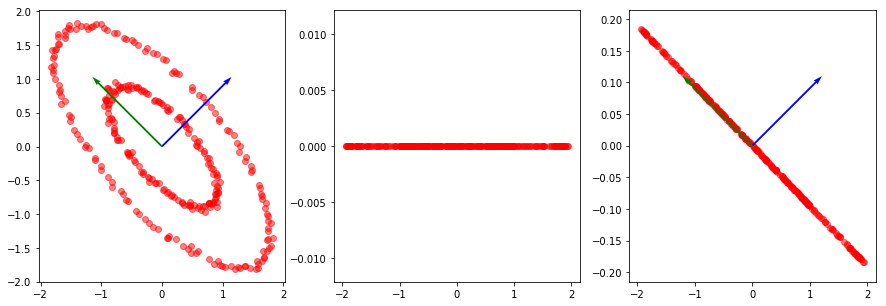

False
False
[[0.995]
 [0.095]]
[0.707 0.707]


In [22]:
# iterative
# w = np.random.uniform(0,1,size=(2,1))
w = np.random.randn(2,1)
w = w/(np.sqrt(np.sum(w**2)))
m = np.zeros_like(w)
temp_X = np.copy(X)

for iter in range(100):
    cum_loss = 0
    temp_X   = shuffle(temp_X)
    for mini_batch in range(0,len(X),10):
        current_batch = temp_X[mini_batch:mini_batch+10]
        loss          = current_batch - current_batch@w@w.T
        grad          = (np.eye(2) + current_batch.T @ current_batch ) @ w
        m = 0.9 * m + 0.1 * grad
        w = w - 0.00000000001* m
        w = w/(np.sqrt(np.sum(w**2)))
        cum_loss      = cum_loss + (loss**2).mean()
    if iter%20==0:print('Iter : ',iter," Loss: ",cum_loss)

projected_mine = X @ w
recover_mine   = projected_mine @ w.T

plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.scatter(X[:, 0], X[:,1], color='red', alpha=0.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[0,0],evector[0,1], color=['b'], scale=2.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[1,0],evector[1,1], color=['g'], scale=2.5)

plt.subplot(1, 3, 2)
plt.scatter(projected_mine,np.zeros(len(projected)), color='red', alpha=0.5)

plt.subplot(1, 3, 3)
plt.scatter(recover_mine[:, 0], recover_mine[:,1], color='red', alpha=0.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[0,0],evector[0,1], color=['b'], scale=2.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[1,0],evector[1,1], color=['g'], scale=2.5)

plt.show()

print(np.allclose(recover_mine,recovered,atol=0.01))
print(np.allclose(np.sign(w)*w,np.sign(evecs[:,0])*evecs[:,0],atol=0.01))
print(np.sign(w)*w)
print(np.sign(evecs[:,0])*evecs[:,0])

Iter :  0  Loss:  22.1361770323052
Iter :  20  Loss:  22.13617703859157
Iter :  40  Loss:  22.136177044894794
Iter :  60  Loss:  22.136177051204065
Iter :  80  Loss:  22.13617705751002


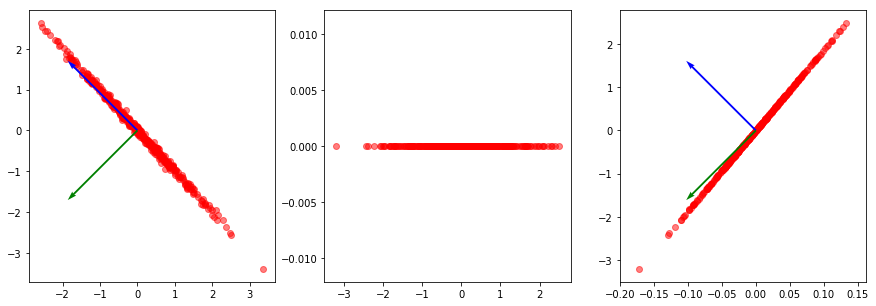

False
False
[[0.05357123]
 [0.99856403]]
[0.70710678 0.70710678]


In [737]:
# iterative
# w = np.random.uniform(0,1,size=(2,1))
w = np.random.randn(2,1)
w = w/(np.sqrt(np.sum(w**2)))
m = np.zeros_like(w)
temp_X = np.copy(X)

for iter in range(100):
    cum_loss = 0
    temp_X   = shuffle(temp_X)
    for mini_batch in range(0,len(X),10):
        current_batch = temp_X[mini_batch:mini_batch+10]
        loss          = current_batch - current_batch@w@w.T
        grad          = (np.eye(2) + current_batch.T @ current_batch ) @ w + (current_batch.T@loss + loss.T @ current_batch) @ w
        m = 0.9 * m + 0.1 * grad
        w = w - 0.00000000000001* m
        w = w/(np.sqrt(np.sum(w**2)))
        cum_loss      = cum_loss + (loss**2).mean()
    if iter%20==0:print('Iter : ',iter," Loss: ",cum_loss)

projected_mine = X @ w
recover_mine   = projected_mine @ w.T

plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.scatter(X[:, 0], X[:,1], color='red', alpha=0.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[0,0],evector[0,1], color=['b'], scale=2.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[1,0],evector[1,1], color=['g'], scale=2.5)

plt.subplot(1, 3, 2)
plt.scatter(projected_mine,np.zeros(len(projected)), color='red', alpha=0.5)

plt.subplot(1, 3, 3)
plt.scatter(recover_mine[:, 0], recover_mine[:,1], color='red', alpha=0.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[0,0],evector[0,1], color=['b'], scale=2.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[1,0],evector[1,1], color=['g'], scale=2.5)

plt.show()

print(np.allclose(recover_mine,recovered,atol=0.01))
print(np.allclose(np.sign(w)*w,np.sign(evecs[:,0])*evecs[:,0],atol=0.01))
print(np.sign(w)*w)
print(np.sign(evecs[:,0])*evecs[:,0])

Iter :  0  Loss:  445.577797402195
Iter :  20  Loss:  445.5777974117294
Iter :  40  Loss:  445.57779742126246
Iter :  60  Loss:  445.5777974307976
Iter :  80  Loss:  445.57779744033024


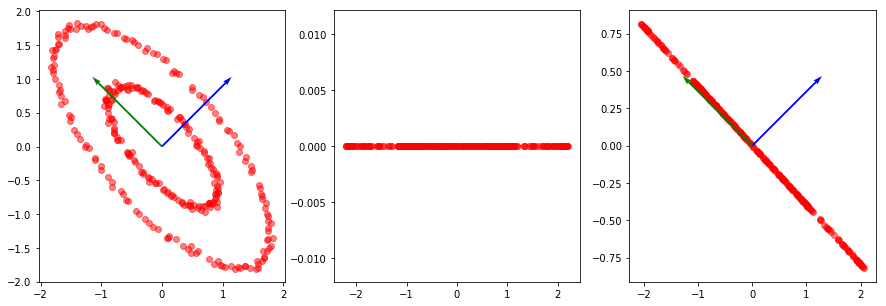

False
False
[[0.929]
 [0.369]]
[[1.]]
[0.707 0.707]


In [23]:
# iterative
# w = np.random.uniform(0,1,size=(2,1))
w1 = np.random.randn(2,1)
w2 = np.random.randn(1,1)
w1 = w1/(np.sqrt(np.sum(w1**2)))
w2 = w2/(np.sqrt(np.sum(w2**2)))

temp_X = np.copy(X)
for iter in range(100):
    cum_loss = 0
    temp_X   = shuffle(temp_X)
    for mini_batch in range(0,len(X),10):
        current_batch = temp_X[mini_batch:mini_batch+10]
        
        layer1 = current_batch @ w1
        layer2 = layer1        @ w2
        
        loss  = w2.T @ layer1.T @ layer1 @ w2
        grad2 = -layer1.T @ layer1 @ w2
        grad1 = current_batch.T@(-layer1@w2@w2.T)
        
        w2 = w2 - 0.00000000000001* grad2
        w1 = w1 - 0.00000000000001* grad1
        w1 = w1/(np.sqrt(np.sum(w1**2)))
        w2 = w2/(np.sqrt(np.sum(w2**2)))
        cum_loss      = cum_loss + loss.mean()
        
    if iter%20==0:print('Iter : ',iter," Loss: ",cum_loss)

projected_mine = X @ w1 @ w2
recover_mine   = projected_mine @ w2.T @ w1.T

plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.scatter(X[:, 0], X[:,1], color='red', alpha=0.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[0,0],evector[0,1], color=['b'], scale=2.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[1,0],evector[1,1], color=['g'], scale=2.5)

plt.subplot(1, 3, 2)
plt.scatter(projected_mine,np.zeros(len(projected)), color='red', alpha=0.5)

plt.subplot(1, 3, 3)
plt.scatter(recover_mine[:, 0], recover_mine[:,1], color='red', alpha=0.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[0,0],evector[0,1], color=['b'], scale=2.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[1,0],evector[1,1], color=['g'], scale=2.5)

plt.show()

print(np.allclose(recover_mine,recovered,atol=0.01))
print(np.allclose(np.sign(w)*w,np.sign(evecs[:,0])*evecs[:,0],atol=0.01))
print(np.sign(w1)*w1)
print(np.sign(w2)*w2)
print(np.sign(evecs[:,0])*evecs[:,0])

Iter :  0  Loss:  511.9759329796187
Iter :  20  Loss:  511.975948377215
Iter :  40  Loss:  511.97594837727155
Iter :  60  Loss:  511.97594837732674
Iter :  80  Loss:  511.9759483773835


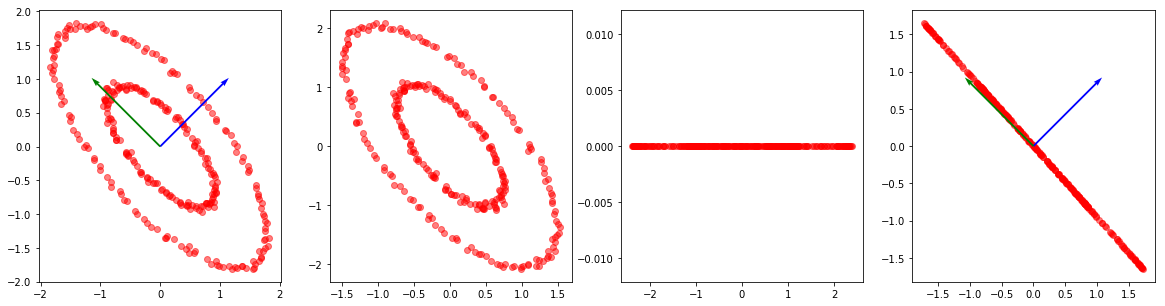

False
False
[[0.225 0.974]
 [0.974 0.225]]
[[0.51]
 [0.86]]
[0.707 0.707]


In [52]:
# iterative (more dim)
# w = np.random.uniform(0,1,size=(2,1))
w1 = np.random.randn(2,2)
w2 = np.random.randn(2,1)
w1 = _sym_decorrelation(w1)
w2 = w2/(np.sqrt(np.sum(w2**2)))

temp_X = np.copy(X)
for iter in range(100):
    cum_loss = 0
    temp_X   = shuffle(temp_X)
    for mini_batch in range(0,len(X),10):
        current_batch = temp_X[mini_batch:mini_batch+10]
        
        layer1 = current_batch @ w1
        layer2 = layer1        @ w2
        loss  = w2.T @ layer1.T @ layer1 @ w2
        grad2 = -layer1.T @ layer1 @ w2
        grad1 = current_batch.T@(-layer1@w2@w2.T)
        
        w2 = w2 - 0.00000000000001* grad2
        w1 = w1 - 0.00000000000001* grad1
        w1 = _sym_decorrelation(w1)
        w2 = w2/(np.sqrt(np.sum(w2**2)))
        cum_loss      = cum_loss + loss.mean()
        
    if iter%20==0:print('Iter : ',iter," Loss: ",cum_loss)

projected_mine = X @ w1 @ w2
recover_mine   = projected_mine @ w2.T @ w1.T

plt.figure(figsize=(20,5))
plt.subplot(1, 4, 1)
plt.scatter(X[:, 0], X[:,1], color='red', alpha=0.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[0,0],evector[0,1], color=['b'], scale=2.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[1,0],evector[1,1], color=['g'], scale=2.5)

plt.subplot(1, 4, 2)
plt.scatter((X @ w1)[:, 0], (X @ w1)[:,1], color='red', alpha=0.5)

plt.subplot(1, 4, 3)
plt.scatter(projected_mine,np.zeros(len(projected)), color='red', alpha=0.5)

plt.subplot(1, 4, 4)
plt.scatter(recover_mine[:, 0], recover_mine[:,1], color='red', alpha=0.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[0,0],evector[0,1], color=['b'], scale=2.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[1,0],evector[1,1], color=['g'], scale=2.5)

plt.show()

print(np.allclose(recover_mine,recovered,atol=0.01))
print(np.allclose(np.sign(w)*w,np.sign(evecs[:,0])*evecs[:,0],atol=0.01))
print(np.sign(w1)*w1)
print(np.sign(w2)*w2)
print(np.sign(evecs[:,0])*evecs[:,0])

Iter :  0  Loss:  204.10296041414742
Iter :  20  Loss:  208.96751249864315
Iter :  40  Loss:  209.19600924278407
Iter :  60  Loss:  200.86034575660037
Iter :  80  Loss:  191.1619049645431


C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\collections.py:874: RuntimeWarning:

invalid value encountered in sqrt



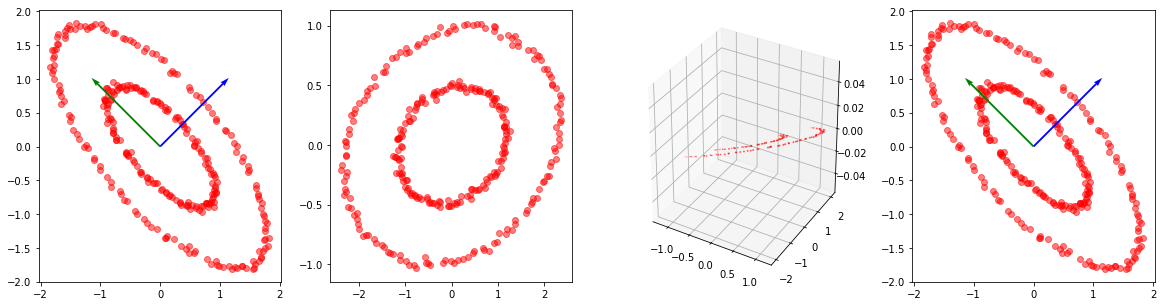

False
False
[[0.774 0.634]
 [0.634 0.774]]
[[0.459 0.874 0.16 ]
 [0.259 0.304 0.917]]
[0.707 0.707]


In [53]:
# iterative (more dim)
# w = np.random.uniform(0,1,size=(2,1))
w1 = np.random.randn(2,2)
w2 = np.random.randn(2,3)
w1 = _sym_decorrelation(w1)
w2 = _sym_decorrelation(w2)

temp_X = np.copy(X)
for iter in range(100):
    cum_loss = 0
    temp_X   = shuffle(temp_X)
    for mini_batch in range(0,len(X),10):
        current_batch = temp_X[mini_batch:mini_batch+10]
        
        layer1 = current_batch @ w1
        layer1 = layer1 + np.random.rand(10,2)
        layer2 = layer1        @ w2
        loss  = w2.T @ layer1.T @ layer1 @ w2
        grad2 = -layer1.T @ layer1 @ w2
        grad1 = current_batch.T@(-layer1@w2@w2.T)
        
        w2 = w2 - 0.00000000000001* grad2
        w1 = w1 - 0.00000000000001* grad1
        w1 = _sym_decorrelation(w1)
        w2 = _sym_decorrelation(w2)
        cum_loss      = cum_loss + loss.mean()
        
    if iter%20==0:print('Iter : ',iter," Loss: ",cum_loss)

projected_mine = X @ w1 @ w2
recover_mine   = projected_mine @ w2.T @ w1.T

plt.figure(figsize=(20,5))
plt.subplot(1, 4, 1)
plt.scatter(X[:, 0], X[:,1], color='red', alpha=0.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[0,0],evector[0,1], color=['b'], scale=2.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[1,0],evector[1,1], color=['g'], scale=2.5)

plt.subplot(1, 4, 2)
plt.scatter((X @ w1)[:, 0], (X @ w1)[:,1], color='red', alpha=0.5)

plt.subplot(1, 4, 3,projection='3d')
plt.scatter(projected_mine[:,0],projected_mine[:,1],projected_mine[:,2], color='red', alpha=0.5)

plt.subplot(1, 4, 4)
plt.scatter(recover_mine[:, 0], recover_mine[:,1], color='red', alpha=0.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[0,0],evector[0,1], color=['b'], scale=2.5)
plt.quiver(X.mean(0)[0], X.mean(0)[1], evector[1,0],evector[1,1], color=['g'], scale=2.5)

plt.show()

print(np.allclose(recover_mine,recovered,atol=0.01))
print(np.allclose(np.sign(w)*w,np.sign(evecs[:,0])*evecs[:,0],atol=0.01))
print(np.sign(w1)*w1)
print(np.sign(w2)*w2)
print(np.sign(evecs[:,0])*evecs[:,0])

In [54]:
# view 3D
trace1 = go.Scatter3d(
    x=projected_mine[:,0],
    y=projected_mine[:,1],
    z=projected_mine[:,2],
    mode='markers',
    line=dict(color='red',width=0.5),
    marker=dict(size=3,opacity=0.3)
)
data = [trace1]
fig  = go.Figure(data=data)
iplot(fig)

In [715]:
# whiten
temp = np.random.randn(2,2)
temp2= _sym_decorrelation(temp)
print(temp)
print(np.sqrt(np.sum(temp**2,0)))
print(temp2)
print(np.sqrt(np.sum(temp2**2,0)))

[[-0.20184052  1.04537128]
 [ 0.53816197  0.81211867]]
[0.57476769 1.32375898]
[[-0.53924154  0.84215115]
 [ 0.84215115  0.53924154]]
[1. 1.]


In [706]:
# gradient
temp = np.random.randn(2,1)
print((np.eye(2)+X.T@X)@temp)
print(temp+X.T@X@temp)
print(X.T@X@temp)

[[-331.01649274]
 [ 330.76155127]]
[[-331.01649274]
 [ 330.76155127]]
[[-330.52681434]
 [ 330.4243461 ]]


In [705]:
# trace
temp = np.random.uniform(size=(5,5))
print(temp)
evalue,evector = np.linalg.eigh(temp)
print(np.diag(temp).sum())
print(evalue.sum())

[[0.59957073 0.4179     0.33564758 0.47885035 0.19466667]
 [0.97630966 0.79208879 0.5297333  0.8280434  0.59174909]
 [0.69528467 0.71563046 0.4198738  0.75446309 0.57951776]
 [0.19209108 0.28379276 0.26153899 0.28961355 0.15620311]
 [0.5442491  0.94424172 0.60280994 0.1614653  0.44792688]]
2.5490737389147675
2.549073738914767


<img src="https://i.imgur.com/Isv9zzD.png" >

# Reference 
1. results, P., & Rieble, N. (2016). PCA in numpy and sklearn produces different results. Cross Validated. Retrieved 9 April 2019, from https://stats.stackexchange.com/questions/235882/pca-in-numpy-and-sklearn-produces-different-results
2. Python, H., & Eunice, J. (2017). How to make two plots side-by-side using Python. Stack Overflow. Retrieved 9 April 2019, from https://stackoverflow.com/questions/42818361/how-to-make-two-plots-side-by-side-using-python
3. The Theorem that the Sum of the Eigenvalues of a Matrix is Equal to its Trace . (2019). Applet-magic.com. Retrieved 9 April 2019, from http://www.applet-magic.com/eigenvaluestrace.htm
4. 